In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
import numpy as np
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import warnings
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings("ignore")
df = pd.read_csv("C:\\Users\\Samir Prasun\\Desktop\\production forecasting\\Avg-Well-Rates.csv")
oil_rate=df.Oil_Prod_Rate.values
stat, p = shapiro(df.Oil_Prod_Rate.values)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')
    
result = adfuller(df.Oil_Prod_Rate.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


df_new = df[['Oil_Prod_Rate','N2_Inj_Rate']]
df_new.tail()





Statistics=0.844, p=0.000
Sample does not look Gaussian (reject H0)
ADF Statistic: -4.260263
p-value: 0.000520


Using TensorFlow backend.


,Oil_Prod_Rate,N2_Inj_Rate
438,754.461300,7.239677e+07
439,776.370132,6.170011e+07
440,762.026283,1.228935e+08
441,679.174343,9.940862e+07
442,709.163886,3.807014e+07






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/100





396/396 [==============================] - 1s 3ms/step - loss: 0.0215
Epoch 2/100
396/396 [==============================] - 1s 2ms/step - loss: 0.0065
Epoch 3/100
396/396 [==============================] - 1s 2ms/step - loss: 0.0030
Epoch 4/100
396/396 [==============================] - 1s 2ms/step - loss: 0.0022
Epoch 5/100
396/396 [==============================] - 1s 2ms/step - loss: 0.0022
Epoch 6/100
396/396 [==============================] - 1s 2ms/step - loss: 0.0018
Epoch 7/100
396/396 [==============================] - 1s 2ms/step - loss: 0.0017
Epoch 8/100
396/396 [==============================] - 1s 2ms/step - loss: 0.0019
Epoch 9/100
396/396 [==============================] - 1s 2ms/step - loss: 0.0021
Epoch 10/100
396/396 [==================

396/396 [==============================] - 1s 3ms/step - loss: 0.0016
Epoch 56/100
396/396 [==============================] - 1s 3ms/step - loss: 0.0017
Epoch 57/100
396/396 [==============================] - 1s 3ms/step - loss: 0.0016
Epoch 58/100
396/396 [==============================] - 1s 3ms/step - loss: 0.0016
0.9522432904181546
0.6907881706598784


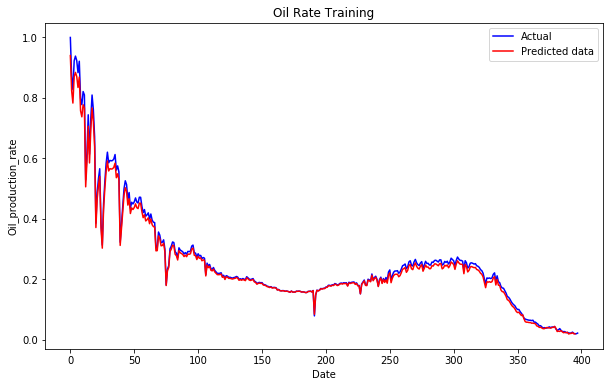

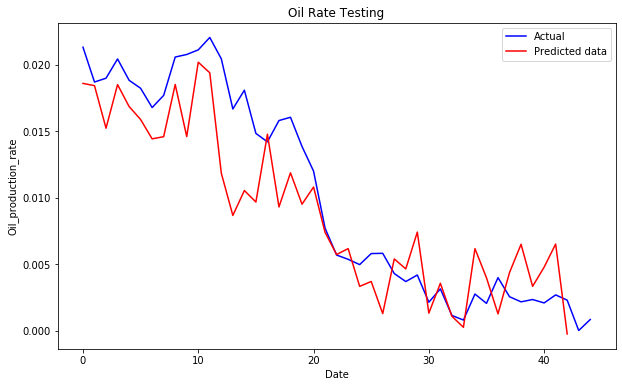

In [2]:
from sklearn.metrics import r2_score

scaler = MinMaxScaler(feature_range = (0, 1))
dataset=df_new.values

dataset[:,0:2] = scaler.fit_transform(dataset[:,:])


train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]



def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 1
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], look_back, 2))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, 2))

lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train.shape[1], 2)))
#lstm_model.add(Dense(50, activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

from tensorflow.keras.callbacks import EarlyStopping
early_Stop = EarlyStopping(monitor='loss', patience = 20, restore_best_weights=True)


lstm_model.fit(X_train, Y_train, epochs=100, callbacks=[early_Stop], batch_size=1)

train_predict = lstm_model.predict(X_train)
test_predict = lstm_model.predict(X_test)

print(r2_score(train_predict, Y_train))
print(r2_score(test_predict, Y_test))
plt.figure(figsize=(10,6))
plt.plot(train[:,0], color='blue', label='Actual')
plt.plot(train_predict, color='red', label='Predicted data')
plt.title('Oil Rate Training')
plt.xlabel('Date')
plt.ylabel('Oil_production_rate')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(test[:,0], color='blue', label='Actual')
plt.plot(test_predict, color='red', label='Predicted data')
plt.title('Oil Rate Testing')
plt.xlabel('Date')
plt.ylabel('Oil_production_rate')
plt.legend()
plt.show()



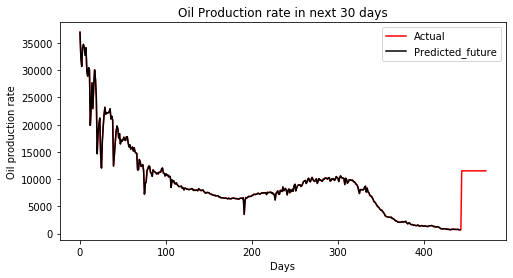

In [7]:
#test_new = np.reshape(test_predict, (test_predict.shape[0], 1, 1))
future = []


currentStep = X_test[-1:,:,:]
for i in range(30):
    currentStep = lstm_model.predict(currentStep)
    Inj=[[3e+08]]
    currentStep=np.concatenate((currentStep,Inj),axis=1)
    currentStep = np.reshape(currentStep, (currentStep.shape[0],look_back, 2)) 
    future.append(currentStep)
lstm_model.reset_states()

Fut=np.array(future)
Fut = np.reshape(Fut, (Fut.shape[0], 2))
Confirmed_new=scaler.inverse_transform(np.array(Fut))


#train_predict_actual = scaler.inverse_transform(train_predict)
#test_predict_actual = scaler.inverse_transform(test_predict)

Oil_combined = np.concatenate([oil_rate,Confirmed_new[:,0]])

fig1 = plt.figure(figsize=(8,4))
plt.plot(Oil_combined, color='red', label='Actual')
plt.plot(oil_rate, color='black', label='Predicted_future')
#plt.plot(train_pre, color='blue', label='Predicted_trained')


plt.title('Oil Production rate in next 30 days')
plt.xlabel('Days')
plt.ylabel('Oil production rate')
#fig1.autofmt_xdate()
plt.legend()
plt.show()